In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer,OneHotEncoder,PolynomialFeatures,StandardScaler,PowerTransformer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,PoissonRegressor,Lasso
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer

import warnings
warnings.filterwarnings("ignore")


In [2]:
df=pd.read_csv('train.csv')

In [3]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
def weekfun(data):
    data['datetime']=pd.to_datetime(data['datetime'])
    data['month']=data['datetime'].dt.month
    data['year']=data['datetime'].dt.year
    data['hour']=data['datetime'].dt.hour
    data.drop('datetime',axis=1,inplace=True)
     
get_fun=FunctionTransformer(weekfun)

get_fun.transform(df)

df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,year,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,2011,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,2011,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2011,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,2011,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,2011,4


##  EDA

<AxesSubplot: xlabel='month', ylabel='count'>

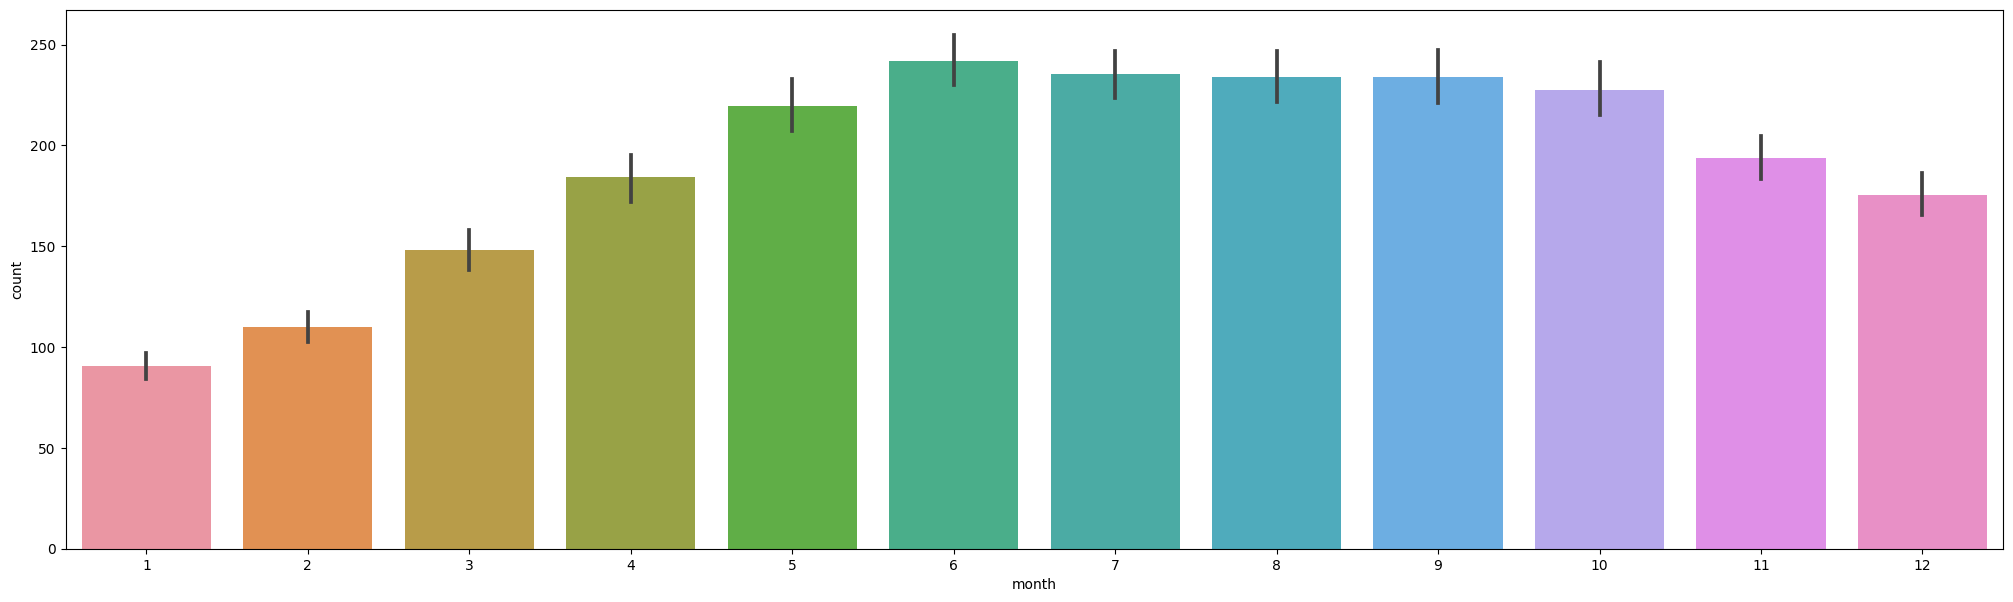

In [5]:
plt.rcParams['figure.figsize']=(25,7)
sns.barplot(data=df,x='month',y='count')

<AxesSubplot: xlabel='season', ylabel='count'>

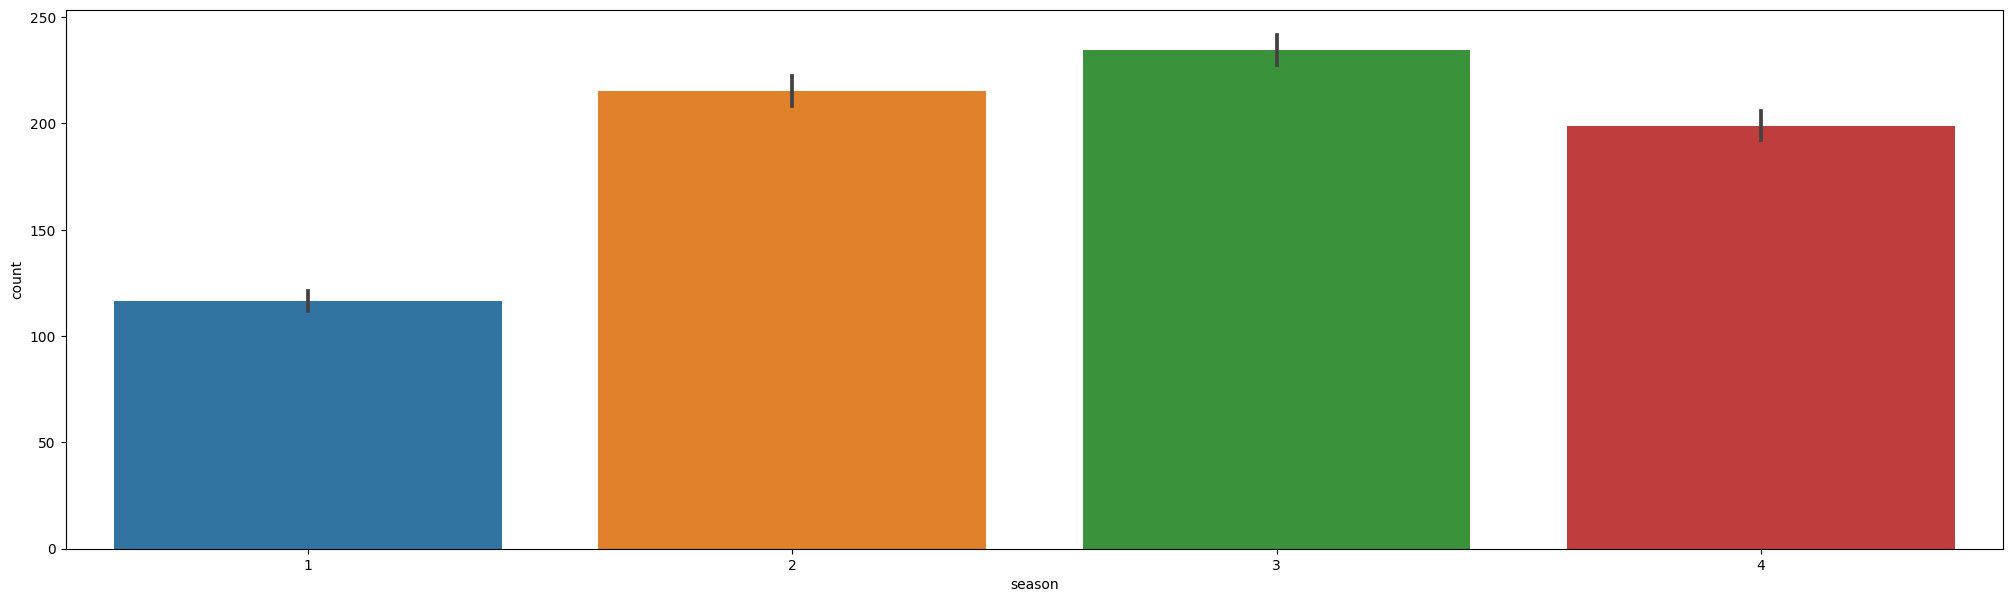

In [6]:
sns.barplot(data=df,x='season',y='count')

<AxesSubplot: xlabel='atemp', ylabel='count'>

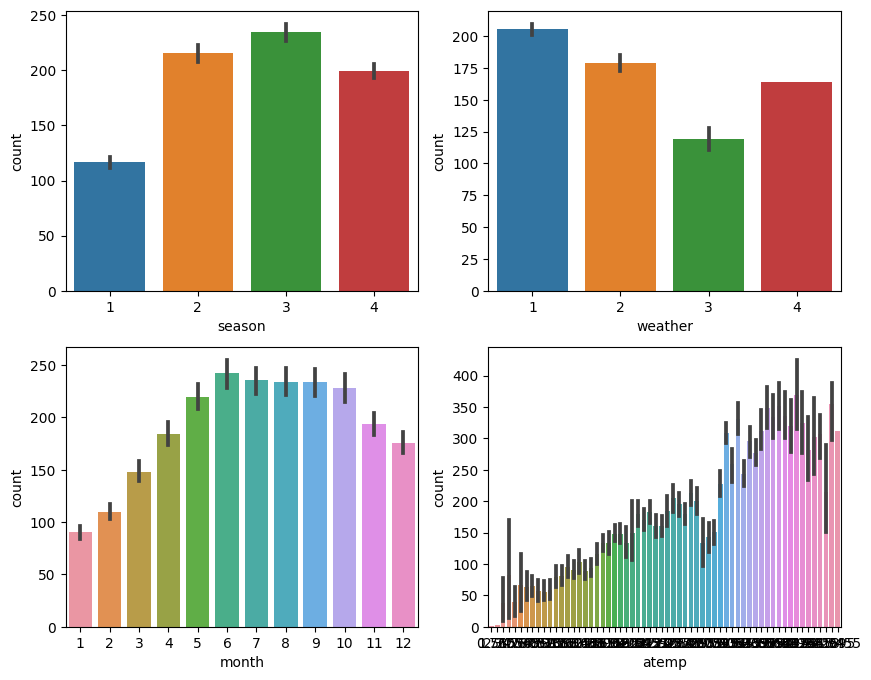

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot on each subplot
sns.barplot(data=df, x='season', y='count',ax=axes[0, 0])
sns.barplot(data=df, x='weather', y='count',ax=axes[0, 1])
sns.barplot(data=df, x='month', y='count',ax=axes[1, 0])
sns.barplot(data=df, x='atemp', y='count',ax=axes[1, 1])

<AxesSubplot: xlabel='workingday', ylabel='count'>

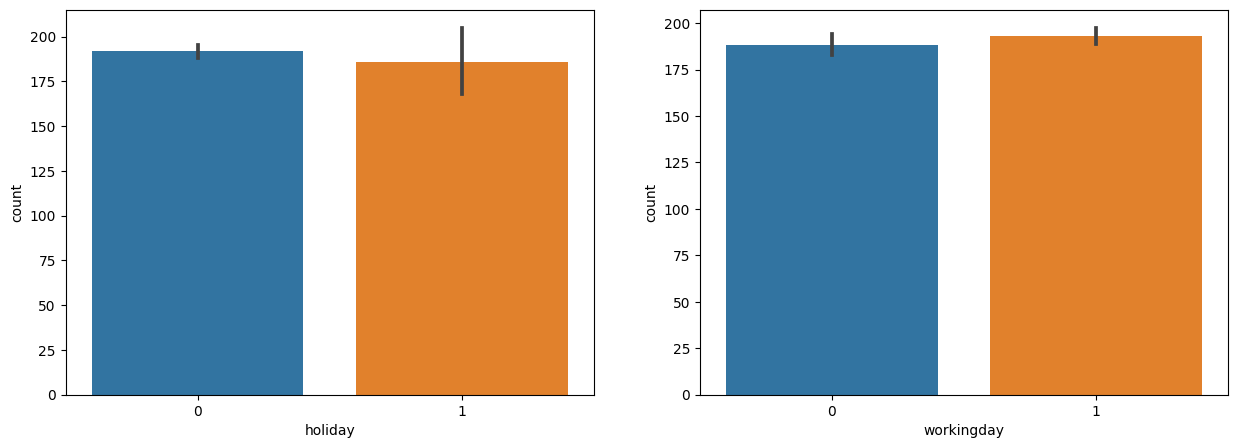

In [8]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

# Plot on each subplot
sns.barplot(data=df, x='holiday', y='count',ax=axes[0])
sns.barplot(data=df, x='workingday', y='count',ax=axes[1])

In [9]:
df.groupby(['workingday','holiday','year'])['count'].mean()

workingday  holiday  year
0           0        2011    144.674684
                     2012    232.771952
            1        2011    152.812500
                     2012    214.389222
1           0        2011    143.696052
                     2012    242.115240
Name: count, dtype: float64

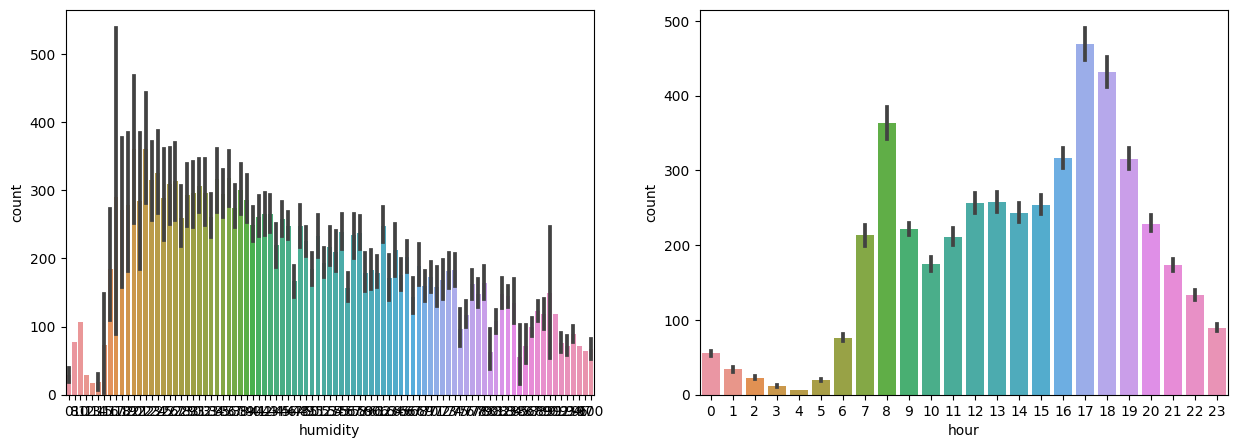

In [10]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))

# Plot on each subplot
sns.barplot(data=df, x='humidity', y='count',ax=axes[0])
sns.barplot(data=df, x='hour', y='count',ax=axes[1]);

<AxesSubplot: xlabel='windspeed', ylabel='count'>

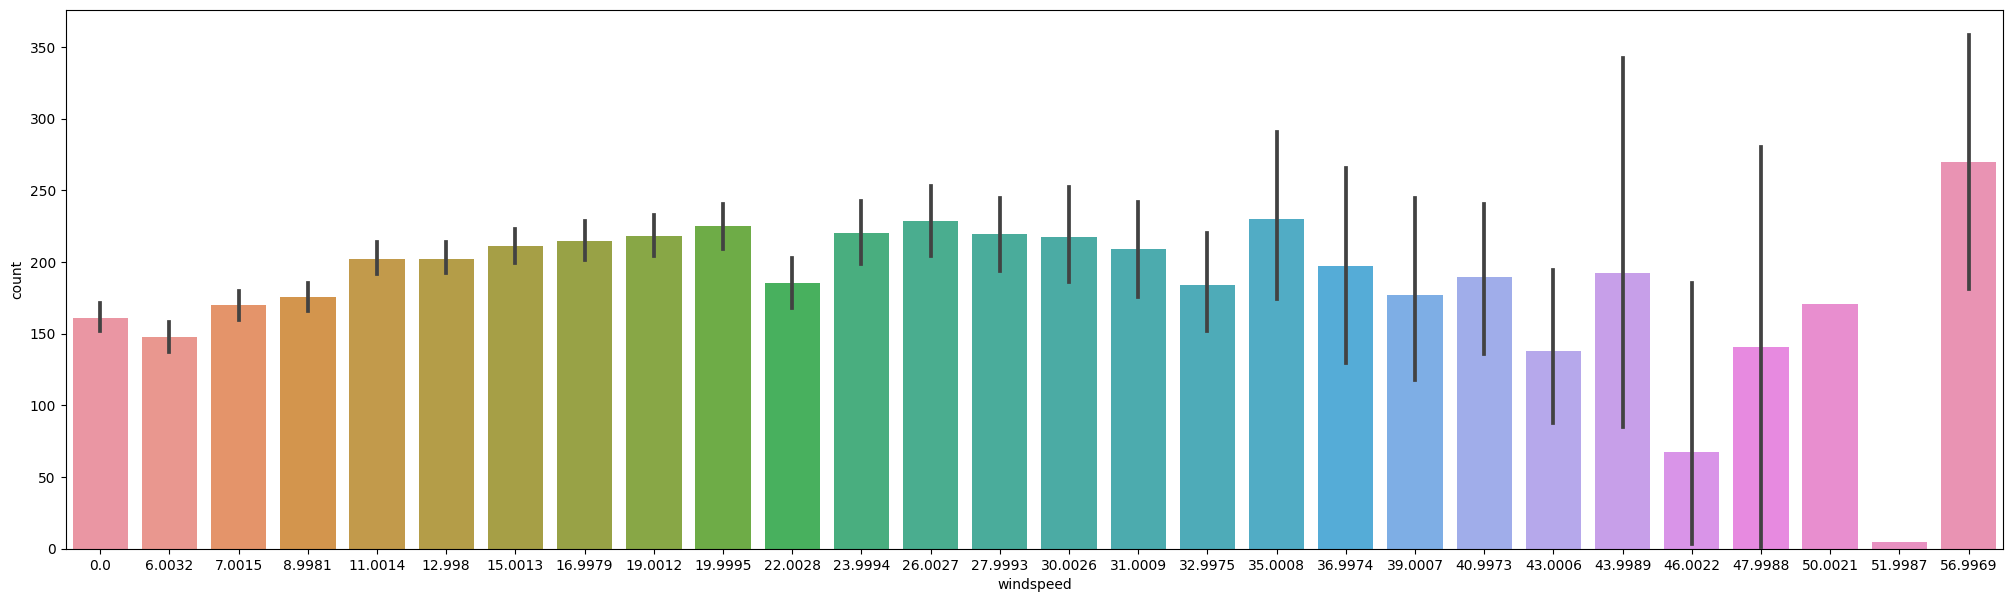

In [11]:
sns.barplot(data=df, x='windspeed', y='count')

In [12]:
df.drop(['temp','casual','registered'],axis=1,inplace=True)

In [13]:
df

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,month,year,hour
0,1,0,0,1,14.395,81,0.0000,16,1,2011,0
1,1,0,0,1,13.635,80,0.0000,40,1,2011,1
2,1,0,0,1,13.635,80,0.0000,32,1,2011,2
3,1,0,0,1,14.395,75,0.0000,13,1,2011,3
4,1,0,0,1,14.395,75,0.0000,1,1,2011,4
...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,19.695,50,26.0027,336,12,2012,19
10882,4,0,1,1,17.425,57,15.0013,241,12,2012,20
10883,4,0,1,1,15.910,61,15.0013,168,12,2012,21
10884,4,0,1,1,17.425,61,6.0032,129,12,2012,22


## Feature Engineering

In [14]:
y=df['count']                  # target
x=df.drop('count',axis=1)     #data

In [15]:
# In weather column replace 4 value by 3
df['weather'].replace({4:3},inplace=True)

In [16]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=14)

In [17]:

date_tran=Pipeline([
    ('my_bin',KBinsDiscretizer(n_bins=4))   
])

ct=ColumnTransformer([
    ('date',date_tran,['atemp','humidity']),
    ('sea_humi',OneHotEncoder(drop='first',handle_unknown='ignore'),['season','year','weather','month','hour']), 
    ('pt',PowerTransformer(),['windspeed'])
],remainder='passthrough')

estimator=Pipeline([
    ('ct',ct),
    ('pol',PolynomialFeatures(degree=4,interaction_only=True)),
    ('model',PoissonRegressor(max_iter=200))
])


In [18]:
estimator.fit(x_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  Pipeline(steps=[('my_bin',
                                                                   KBinsDiscretizer(n_bins=4))]),
                                                  ['atemp', 'humidity']),
                                                 ('sea_humi',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['season', 'year', 'weather',
                                                   'month', 'hour']),
                                                 ('pt', PowerTransformer(),
                                                  ['windspeed'])])),
                ('pol', PolynomialFeatures(degree=4, interaction_only=True)),
                ('model', PoissonRegressor(max_iter=200))])

In [19]:
estimator.score(x_train,y_train)

0.949985712884436

In [20]:
estimator.score(x_test,y_test)

0.9083953916050159

In [21]:
y_pred=estimator.predict(x_train)
from sklearn.metrics import mean_squared_error,r2_score
rmse=np.sqrt(mean_squared_error(y_train,y_pred))
r2=r2_score(y_train,y_pred)
print(f'rmse:{rmse}, r2:{r2}')

rmse:34.14369765531674, r2:0.9651061281282889


In [22]:
estimator.get_params()

{'memory': None,
 'steps': [('ct', ColumnTransformer(remainder='passthrough',
                     transformers=[('date',
                                    Pipeline(steps=[('my_bin',
                                                     KBinsDiscretizer(n_bins=4))]),
                                    ['atemp', 'humidity']),
                                   ('sea_humi',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore'),
                                    ['season', 'year', 'weather', 'month',
                                     'hour']),
                                   ('pt', PowerTransformer(), ['windspeed'])])),
  ('pol', PolynomialFeatures(degree=4, interaction_only=True)),
  ('model', PoissonRegressor(max_iter=200))],
 'verbose': False,
 'ct': ColumnTransformer(remainder='passthrough',
                   transformers=[('date',
                                  Pipeline(steps=[('my_bin'

In [23]:
prm_grd={
    'pol__degree': [3,4],
    'model__alpha': [10,1.0,0.1,0.01],
}

In [24]:
from sklearn.metrics import make_scorer,mean_squared_log_error

def my_scorer(y_true,y_pred,**kwargs):
   return mean_squared_log_error(y_true,y_pred,squared=False,**kwargs)

rmsle_scorer=make_scorer(my_scorer,greater_is_better=False)

rmsle_scorer(estimator,x_train,y_train)

-0.5464187609197317

In [31]:
gscv1=GridSearchCV(
    estimator=estimator,
    param_grid=prm_grd,
    n_jobs=-1,
    cv=5,
    verbose=1,
    scoring=rmsle_scorer)

In [32]:
gscv1.fit(x_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/akshayrote/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/akshayrote/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


KeyboardInterrupt: 

array([405.83013221])